Librerie

In [1]:
import os
import torch
import numpy as np
import pandas as pd
from scipy.io import wavfile as wav
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.svm import SVC
import IPython.display as ipd
import zipfile
from shutil import copyfile
import librosa
import librosa.display as lid
from sklearn.preprocessing import scale
from librosa.feature.spectral import mfcc

## Dataset import

Questo dataset raccoglie audio di 4 persone differenti

In [2]:
zip = zipfile.ZipFile('/recordings.zip')
zip.extractall()
zip.close()

Esempio di audio

In [3]:
rate, audio = wav.read('./16000_pcm_speeches/Julia_Gillard/1012.wav')
ipd.Audio(audio, rate=rate)

## Data loader

In [4]:
def identity(input):
    return input

# Data loader
def load_data(feature_extractor=identity, normalize=False):

    labels = []
    features = []

    for f in sorted(os.listdir('./16000_pcm_speeches/Julia_Gillard')):
        if f.endswith('.wav'):
            rate, signal = wav.read('./16000_pcm_speeches/Julia_Gillard/' + f)
            cur_features = feature_extractor(signal, rate)
            features.append(cur_features)
            # lable
            labels.append("Julia")

    for f in sorted(os.listdir('./16000_pcm_speeches/Jens_Stoltenberg')):
        if f.endswith('.wav'):
            rate, signal = wav.read('./16000_pcm_speeches/Jens_Stoltenberg/' + f)
            cur_features = feature_extractor(signal, rate)
            features.append(cur_features)
            # lable
            labels.append("Jens")

    for f in sorted(os.listdir('./16000_pcm_speeches/Benjamin_Netanyau')):
        if f.endswith('.wav'):
            rate, signal = wav.read('./16000_pcm_speeches/Benjamin_Netanyau/' + f)
            cur_features = feature_extractor(signal, rate)
            features.append(cur_features)
            # lable
            labels.append("Benjamin")

    for f in sorted(os.listdir('./16000_pcm_speeches/Magaret_Tarcher')):
        if f.endswith('.wav'):
            rate, signal = wav.read('./16000_pcm_speeches/Magaret_Tarcher/' + f)
            cur_features = feature_extractor(signal, rate)
            features.append(cur_features)
            # lable
            labels.append("Magaret")

    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.1, random_state=1)

    if normalize:
        eps = 0.001
        X_train = np.array(X_train)
        X_train_mean = X_train.mean(axis=0)
        X_train_std = X_train.std(axis=0)
        X_train = (X_train - X_train_mean + eps)/(X_train_std + eps)
        X_train = [row for row in X_train]

        X_test = [row for row in (np.array(X_test) - X_train_mean + eps)/(X_train_std + eps)]

    return X_train, X_test, y_train, y_test

## Features

Elenco di funzioni utilizzate come feature extraction

In [5]:
#standard deviation
def sdev(input):
    return np.std(input, keepdims=True)

#absolute average
def aavg(input):
    return np.mean(np.abs(input), keepdims=True)

#durata
def duration(input):
    return input.shape

#energia segnale
def energy(input):
    return np.sum((input*1.0)**2, keepdims=True)

#zero crossing rate
def zcr(input):
    input_sign = np.sign(input)
    return np.array([0.5 * np.sum(np.absolute(np.sum([input_sign[:-1], -1 * input_sign[1:]], axis=0)))])

#Mel-frequency cepstral coefficients
def mel(input, rate):
    input = input.astype(float)
    return np.mean(librosa.feature.mfcc(y=input, sr=rate, n_mfcc=40).T,axis=0)

La feature extraction mfcc è ampiamente usata per identificare la "forma" dei tratti vocali osservati.

# Modello SVM con feature extraction base

Combinazione delle features

In [6]:
def combo(input, rate):
    return np.concatenate((aavg(input),sdev(input),duration(input),energy(input),zcr(input)))

Creazione dei subset

In [7]:
X_train, X_test, y_train, y_test = load_data(feature_extractor=combo, normalize=True)

In [8]:
len(X_train)

5400

## Training modello

Allenamento del modello

In [9]:
#parametri cross-validation
param_grid = {'C': [1e2, 5e2, 1e3],
          'gamma': [0.005, 0.01, 0.1, 0.5, 1.0], }

clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid, cv=2)
clf = clf.fit(X_train, y_train)

In [11]:
clf.best_estimator_

SVC(C=500.0, class_weight='balanced', gamma=0.5)

## Testing

In [10]:
y_pred = clf.predict(X_test)

#Report
print('Classification report:')
print(classification_report(y_test, y_pred))

#Confusion matrix
print('Confusion matrix:')
cm = confusion_matrix(y_test, y_pred)
print(cm)

Classification report:
              precision    recall  f1-score   support

    Benjamin       0.71      0.79      0.75       151
        Jens       0.78      0.70      0.74       150
       Julia       0.90      0.85      0.88       148
     Magaret       0.79      0.82      0.81       152

    accuracy                           0.79       601
   macro avg       0.80      0.79      0.79       601
weighted avg       0.80      0.79      0.79       601

Confusion matrix:
[[120  23   1   7]
 [ 27 105   5  13]
 [  5   4 126  13]
 [ 17   2   8 125]]


# Modello SVM con aggiunta di feature extraction MFCC

Combinazione delle features

In [12]:
def combo(input, rate):
    return np.concatenate((aavg(input),sdev(input),duration(input),energy(input),zcr(input), mel(input, rate)))

Creazione dei subset

In [13]:
X_train, X_test, y_train, y_test = load_data(feature_extractor=combo, normalize=True)

## Training

In [14]:
#parametri cross-validation
param_grid = {'C': [1e2, 5e2, 1e3],
          'gamma': [0.005, 0.01, 0.1, 0.5, 1.0], }

clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid, cv=2)
clf = clf.fit(X_train, y_train)

In [16]:
clf.best_estimator_

SVC(C=100.0, class_weight='balanced', gamma=0.005)

## Testing

In [17]:
y_pred = clf.predict(X_test)

#Report
print('Classification report:')
print(classification_report(y_test, y_pred))

#Confusion matrix
print('Confusion matrix:')
cm = confusion_matrix(y_test, y_pred)
print(cm)

Classification report:
              precision    recall  f1-score   support

    Benjamin       1.00      1.00      1.00       151
        Jens       1.00      0.99      1.00       150
       Julia       0.99      1.00      1.00       148
     Magaret       1.00      1.00      1.00       152

    accuracy                           1.00       601
   macro avg       1.00      1.00      1.00       601
weighted avg       1.00      1.00      1.00       601

Confusion matrix:
[[151   0   0   0]
 [  0 149   1   0]
 [  0   0 148   0]
 [  0   0   0 152]]


# Osservazioni

Con la semplice aggiunta della funzione mfcc ai parametri di feature extraction, si è passati da un accuracy del 79% al 100% mantenendo lo stesso modello.
Tuttavia un valore cosi alto fa pensare che i dati contengano qualche forma di bias, per esempio il modello potrebbe essere diventato accurato a discriminare i diversi microfoni che sono stati usati piuttosto che le persone. Per questo motivo ho deciso di operare della data augmentation e studiare i risultati

# Modello SVM con aggiunta di feature extraction MFCC e data augmentation

### Data augmentation

Funzioni di data augmenteation

In [18]:
#aggiunta rumore
def noise(data, noise_factor):
    augmented_data = data + noise_factor*np.random.normal(0,1,len(data))
    return augmented_data

#time shifting
def time_shifting(data):
    return np.roll(data,int(rate/10))

Funzione che applica le data augmentation con i metodi precedenti

In [19]:
def data_aug(input):
    # apply data augmentation functions
    input = noise(input, 2000)
    input = time_shifting(input)
    return input

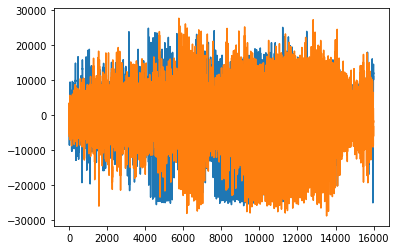

In [20]:
#esempio di modifica segnale con data augmentation
plt.plot(audio)
plt.plot(data_aug(audio))

### Data load

In [21]:
def combo(input, rate):
    input = data_aug(input)
    return np.concatenate((aavg(input),sdev(input),duration(input),energy(input),zcr(input), mel(input, rate)))

In [22]:
X_train, X_test, y_train, y_test = load_data(feature_extractor=combo, normalize=True)

## Training modello

In [23]:
#parametri cross-validation
param_grid = {'C': [1e2, 5e2, 1e3],
          'gamma': [0.005, 0.01, 0.1, 0.5, 1.0], }

clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid, cv=2)
clf = clf.fit(X_train, y_train)

In [24]:
clf.best_estimator_

SVC(C=100.0, class_weight='balanced', gamma=0.01)

# Testing

In [25]:
y_pred = clf.predict(X_test)

#Report
print('Classification report:')
print(classification_report(y_test, y_pred))

#Confusion matrix
print('Confusion matrix:')
cm = confusion_matrix(y_test, y_pred)
print(cm)

Classification report:
              precision    recall  f1-score   support

    Benjamin       0.95      0.94      0.95       151
        Jens       0.94      0.98      0.96       150
       Julia       0.99      0.99      0.99       148
     Magaret       0.98      0.95      0.97       152

    accuracy                           0.97       601
   macro avg       0.97      0.97      0.97       601
weighted avg       0.97      0.97      0.97       601

Confusion matrix:
[[142   7   0   2]
 [  2 147   0   1]
 [  1   0 147   0]
 [  4   2   1 145]]


# Osservazioni
Accuracy leggermente ridotta rispetto al caso senza data augmentation. Tuttavia questo modello è preferibile al precedente poichè generalizza meglio i dati 